In [ ]:
# Install libraries
!pip install seedir
!pip install emoji
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seedir as sd
from zipfile import ZipFile
import plotly.express as px
import shutil
import cv2
import glob
from PIL import Image, ImageDraw
import json
import itertools

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stanford-cropped-images/names.csv
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/new-new-06156.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/06270.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/03575.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/07155.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/05238.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/new-new-02494.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/02753.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_va

In [ ]:
names = pd.read_csv("/kaggle/input/stanford-cropped-images/names.csv")

In [ ]:
names.head()

,Unnamed: 0,class_name,class_number
0,0,AM General Hummer SUV 2000,1
1,1,Acura RL Sedan 2012,2
2,2,Acura TL Sedan 2012,3
3,3,Acura TL Type-S 2008,4
4,4,Acura TSX Sedan 2012,5


In [ ]:
## deep learning
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Input, Conv1D, Conv2D, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2S
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import efficientnet, EfficientNetV2L
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
train_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/train/*/*")
test_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/test/*/*")
valid_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/*/*")

In [ ]:
model_names = names["class_name"].values.tolist()

In [ ]:
## setting up some parameters for data augmentation
img_width, img_height = 224, 224
train_samples = len(train_car)
validation_samples = len(test_car)
testing_samples = len(valid_car)
## there are 196 different models
n_classes = len(model_names)
batch_size = 32

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

## performing augmentation on the training data
"""train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()"""
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/train"
test_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/test"
valid_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/"

In [ ]:
## converting data to a tf.data.Dataset object
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

testing_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 12950 images belonging to 196 classes.
Found 1597 images belonging to 196 classes.
Found 1638 images belonging to 196 classes.


## EfficientNetB1

In [ ]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB1(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_2 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

27018416/27018416 [==============================] - 0s 0us/step


In [ ]:
## compile model, define optimizer and the loss function
model_2.compile(loss='categorical_crossentropy',
              optimizer="Adam", metrics=['accuracy'])

In [ ]:
## train the model
history_2 = model_2.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


2023-04-14 09:56:42.981011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


405/405 [==============================] - 412s 919ms/step - loss: 4.4725 - accuracy: 0.1180 - val_loss: 5.1891 - val_accuracy: 0.0194
Epoch 2/20
405/405 [==============================] - 273s 673ms/step - loss: 2.5866 - accuracy: 0.4258 - val_loss: 2.0939 - val_accuracy: 0.5053
Epoch 3/20
405/405 [==============================] - 269s 664ms/step - loss: 1.6335 - accuracy: 0.6120 - val_loss: 1.3868 - val_accuracy: 0.6544
Epoch 4/20
405/405 [==============================] - 267s 658ms/step - loss: 1.1764 - accuracy: 0.7056 - val_loss: 1.0523 - val_accuracy: 0.7264
Epoch 5/20
405/405 [==============================] - 272s 672ms/step - loss: 0.9224 - accuracy: 0.7659 - val_loss: 0.8457 - val_accuracy: 0.7790
Epoch 6/20
405/405 [==============================] - 273s 674ms/step - loss: 0.7441 - accuracy: 0.8057 - val_loss: 0.7720 - val_accuracy: 0.7984
Epoch 7/20
405/405 [==============================] - 266s 656ms/step - loss: 0.6051 - accuracy: 0.8399 - val_loss: 0.6993 - val_accura

In [ ]:
model_results = model_2.evaluate(testing_generator)

52/52 [==============================] - 25s 492ms/step - loss: 0.5384 - accuracy: 0.8596


In [ ]:
import matplotlib.pyplot as plt

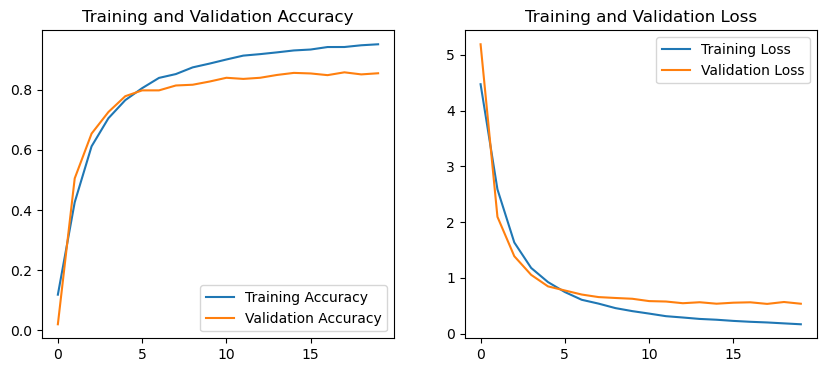

In [ ]:
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save the weights
model_2.save_weights('/kaggle/working/efficientnetB1_weights.h5')

## EfficientNetV2L

In [ ]:
## loading the EfficientNetB1 model
base_model = EfficientNetV2L(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_9 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

473176280/473176280 [==============================] - 2s 0us/step


In [ ]:
## compile model, define optimizer and the loss function
model_9.compile(loss='categorical_crossentropy',
              optimizer="Adam", metrics=['accuracy'])

In [ ]:
## train the model
history_9 = model_9.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


2023-04-14 11:34:12.891367: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


405/405 [==============================] - 631s 1s/step - loss: 4.8148 - accuracy: 0.0600 - val_loss: 3.6973 - val_accuracy: 0.1960
Epoch 2/20
405/405 [==============================] - 530s 1s/step - loss: 3.0142 - accuracy: 0.3210 - val_loss: 1.9507 - val_accuracy: 0.5366
Epoch 3/20
405/405 [==============================] - 528s 1s/step - loss: 1.7764 - accuracy: 0.5708 - val_loss: 1.2172 - val_accuracy: 0.6863
Epoch 4/20
405/405 [==============================] - 530s 1s/step - loss: 1.1819 - accuracy: 0.6957 - val_loss: 0.8845 - val_accuracy: 0.7683
Epoch 5/20
405/405 [==============================] - 529s 1s/step - loss: 0.8638 - accuracy: 0.7761 - val_loss: 0.6872 - val_accuracy: 0.8147
Epoch 6/20
405/405 [==============================] - 529s 1s/step - loss: 0.6607 - accuracy: 0.8202 - val_loss: 0.5899 - val_accuracy: 0.8460
Epoch 7/20
405/405 [==============================] - 531s 1s/step - loss: 0.5310 - accuracy: 0.8514 - val_loss: 0.5440 - val_accuracy: 0.8478
Epoch 8/20

In [ ]:
model_results = model_9.evaluate(testing_generator)

52/52 [==============================] - 21s 403ms/step - loss: 0.3983 - accuracy: 0.9054


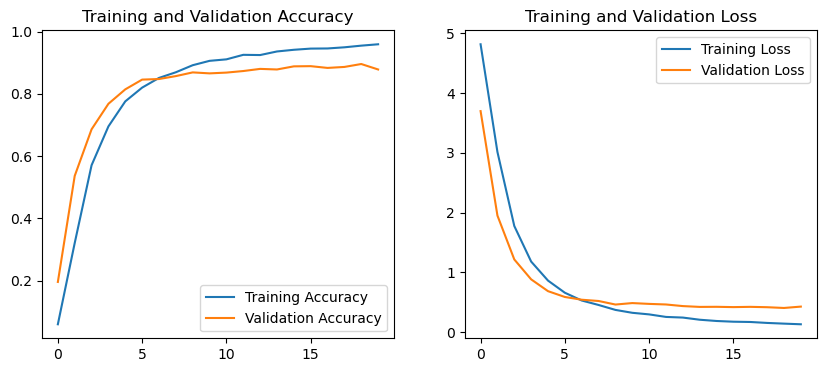

In [ ]:
acc_2 = history_9.history['accuracy']
val_acc_2 = history_9.history['val_accuracy']

loss_2 = history_9.history['loss']
val_loss_2 = history_9.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save the weights
model_9.save_weights('/kaggle/working/EfficientNetV2L_weights.h5')

## InceptronV3

In [ ]:
"""from keras.applications.inception_v3 import InceptionV3"""

'from keras.applications.inception_v3 import InceptionV3'

In [ ]:
"""## loading the EfficientNetB1 model
base_model = InceptionV3(weights=None, include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_3 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()"""

"## loading the EfficientNetB1 model\nbase_model = InceptionV3(weights=None, include_top=False)\n\n## adding some extra layers\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\npredictions = Dense(196, activation='softmax')(x)\nmodel_3 = Model(inputs=base_model.input, outputs=predictions)\n\n## fix the feature extraction part of the model\nfor layer in base_model.layers:\n    if isinstance(layer, BatchNormalization):\n        layer.trainable = True\n    else:\n        layer.trainable = False\n\n\n# model_2.summary()"

In [ ]:
"""## compile model, define optimizer and the loss function
model_3.compile(loss='categorical_crossentropy',
              optimizer="Adam", metrics=['accuracy'])"""

'## compile model, define optimizer and the loss function\nmodel_3.compile(loss=\'categorical_crossentropy\',\n              optimizer="Adam", metrics=[\'accuracy\'])'

In [ ]:
## train the model
"""history_3 = model_3.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)"""

'history_3 = model_3.fit_generator(generator=train_generator,\n                    steps_per_epoch=len(train_generator) ,\n                    validation_data=validation_generator,\n                    validation_steps=len(validation_generator),\n                    epochs=20)'

In [ ]:
"""model_results = model_3.evaluate(testing_generator)"""

'model_results = model_3.evaluate(testing_generator)'

In [ ]:
"""acc_2 = history_3.history['accuracy']
val_acc_2 = history_3.history['val_accuracy']

loss_2 = history_3.history['loss']
val_loss_2 = history_3.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()"""

"acc_2 = history_3.history['accuracy']\nval_acc_2 = history_3.history['val_accuracy']\n\nloss_2 = history_3.history['loss']\nval_loss_2 = history_3.history['val_loss']\n\nepochs_range = range(20)\n\nplt.figure(figsize=(10, 4))\nplt.subplot(1, 2, 1)\nplt.plot(epochs_range, acc_2, label='Training Accuracy')\nplt.plot(epochs_range, val_acc_2, label='Validation Accuracy')\nplt.legend(loc='lower right')\nplt.title('Training and Validation Accuracy')\n\nplt.subplot(1, 2, 2)\nplt.plot(epochs_range, loss_2, label='Training Loss')\nplt.plot(epochs_range, val_loss_2, label='Validation Loss')\nplt.legend(loc='upper right')\nplt.title('Training and Validation Loss')\nplt.show()"

## EfficientNetB7

In [ ]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB7(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_4 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

258076736/258076736 [==============================] - 3s 0us/step


In [ ]:
## compile model, define optimizer and the loss function
model_4.compile(loss='categorical_crossentropy',
              optimizer="Adam", metrics=['accuracy'])

In [ ]:
## train the model
history_4 = model_4.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


2023-04-14 14:40:21.692449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/405 [..............................] - ETA: 7:58:16 - loss: 5.3183 - accuracy: 0.0000e+00

ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/block7c_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23/2630819285.py", line 6, in <module>
      epochs=20)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2618, in fit_generator
      initial_epoch=initial_epoch,
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 866, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 660, in _fused_batch_norm
      training, _fused_batch_norm_training, _fused_batch_norm_inference
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/control_flow_util.py", line 109, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 644, in _fused_batch_norm_training
      exponential_avg_factor=exponential_avg_factor,
Node: 'model_2/block7c_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,3840,7,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/block7c_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_274248]

In [ ]:
model_results = model_4.evaluate(testing_generator)

In [ ]:
acc_2 = history_4.history['accuracy']
val_acc_2 = history_4.history['val_accuracy']

loss_2 = history_4.history['loss']
val_loss_2 = history_4.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save the weights
model_4.save_weights('/kaggle/working/efficientnetB7_weights.h5')

## MobileNetV2

In [ ]:
IMG_SHAPE = (224,224,3)

In [ ]:
#Fine tuning base model to better suit our application, small learning rate
"""IMG_SHAPE = (224,224,3)

base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_5 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False"""

In [ ]:
## compile model, define optimizer and the loss function
"""model_5.compile(loss='categorical_crossentropy',
              optimizer = tensorflow.keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])"""

In [ ]:
## train the model
"""history_5 = model_5.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)"""

In [ ]:
"""model_results = model_5.evaluate(testing_generator)"""

In [ ]:
"""acc_2 = history_5.history['accuracy']
val_acc_2 = history_5.history['val_accuracy']

loss_2 = history_5.history['loss']
val_loss_2 = history_5.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()"""

In [ ]:
# save entire model to a HDF5 file
#model_5.save('/kaggle/working/mobilenetV2.h5')

In [ ]:
# save the weights
#model_5.save_weights('/kaggle/working/mobilenetV2_weights.h5')

In [ ]:
#from IPython.display import FileLink
#FileLink(r'/kaggle/working/mobilenetV2_weights.h5')

## EfficientNetV2S

In [ ]:
## loading the EfficientNetB1 model
base_model = EfficientNetV2S(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_8 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

In [ ]:
## compile model, define optimizer and the loss function
model_8.compile(loss='categorical_crossentropy',
              optimizer = tensorflow.keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [ ]:
## train the model
history_8 = model_8.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

In [ ]:
model_results = model_8.evaluate(testing_generator)

In [ ]:
acc_2 = history_8.history['accuracy']
val_acc_2 = history_8.history['val_accuracy']

loss_2 = history_8.history['loss']
val_loss_2 = history_8.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save the weights
model_8.save_weights('/kaggle/working/EfficientNetV2S.h5')